# 신용카드 디폴트 찾기

# 데이터
- 2005년 대만은행 제공
- 대출 총액(limit_bill), 과거 상환 내역등을 보고 다음달 디폴트 예측
- 이전 6개월의 상환 상태 (payment status): PAY
- 이전 6개월의 청구 금액 (bill statement): BILL_AMT
- 이전 6개월의 상환 현황 (previous payment): PAY_AMT

## import

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [106]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.figsize'] = [8, 6]

In [107]:
!curl -o default.xls https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5409k  100 5409k    0     0   798k      0  0:00:06  0:00:06 --:--:--  873k


In [108]:
df = pd.read_excel('default.xls', skiprows=1, index_col=0)
print(df.shape)
df[:3]

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

## 컬럼명 정리
- 대소문자, 띄어쓰기 처리

In [110]:
df.columns.str.lower().str.replace(" ", "_")

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')

In [111]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df[:3].T

ID,1,2,3
limit_bal,20000,120000,90000
sex,2,2,2
education,2,2,2
marriage,1,2,2
age,24,26,34
pay_0,2,-1,0
pay_2,2,2,0
pay_3,-1,0,0
pay_4,-1,0,0
pay_5,-2,0,0


In [112]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
variables = ['payment_status', 'bill_statement', 'previous_payment']
new_column_names = [x + '_' + y for x in variables for y in months]
new_column_names

['payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

In [113]:
rename_dict = {x: y for x, y in zip(df.loc[:, 'pay_0':'pay_amt6'].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)
df.head().T

ID,1,2,3,4,5
limit_bal,20000,120000,90000,50000,50000
sex,2,2,2,2,1
education,2,2,2,2,2
marriage,1,2,2,1,1
age,24,26,34,37,57
payment_status_sep,2,-1,0,0,-1
payment_status_aug,2,2,0,0,0
payment_status_jul,-1,0,0,0,-1
payment_status_jun,-1,0,0,0,0
payment_status_may,-2,0,0,0,0


## 카테고리 변수 처리

In [114]:
# 알려져 있는 인코딩 값을 카테고리 변수로 표현 (숫자--> 문자열)
gender_dict = {1: 'Male', 
               2: 'Female'}
education_dict = {0: 'Others',
                  1: 'Graduate school', 
                  2: 'University', 
                  3: 'High school', 
                  4: 'Others',
                  5: 'Others',
                  6: 'Others'}
marital_status_dict = {0: 'Others', 
                       1: 'Married', 
                       2: 'Single', 
                       3: 'Others'}
payment_status = {-2: 'Unknown',
                  -1: 'Payed duly',
                  0: 'Unknown',
                  1: 'Payment delayed 1 month',
                  2: 'Payment delayed 2 months',
                  3: 'Payment delayed 3 months',
                  4: 'Payment delayed 4 months',
                  5: 'Payment delayed 5 months',
                  6: 'Payment delayed 6 months',
                  7: 'Payment delayed 7 months',
                  8: 'Payment delayed 8 months',
                  9: 'Payment delayed >= 9 months'}

# 숫자로된 인코딩을 문자열로 변환
df.sex = df.sex.map(gender_dict)
df.education = df.education.map(education_dict)
df.marriage = df.marriage.map(marital_status_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  int64 
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  int64 
 5   payment_status_sep          30000 non-null  int64 
 6   payment_status_aug          30000 non-null  int64 
 7   payment_status_jul          30000 non-null  int64 
 8   payment_status_jun          30000 non-null  int64 
 9   payment_status_may          30000 non-null  int64 
 10  payment_status_apr          30000 non-null  int64 
 11  bill_statement_sep          30000 non-null  int64 
 12  bill_statement_aug          30000 non-null  int64 
 13  bill_statement_jul          30000 non-null  in

In [115]:
for column in [x for x in df.columns if ('status' in x)]:
    df[column] = df[column].map(payment_status)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  int64 
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  int64 
 5   payment_status_sep          30000 non-null  object
 6   payment_status_aug          30000 non-null  object
 7   payment_status_jul          30000 non-null  object
 8   payment_status_jun          30000 non-null  object
 9   payment_status_may          30000 non-null  object
 10  payment_status_apr          30000 non-null  object
 11  bill_statement_sep          30000 non-null  int64 
 12  bill_statement_aug          30000 non-null  int64 
 13  bill_statement_jul          30000 non-null  in

In [116]:
df[:3].T

ID,1,2,3
limit_bal,20000,120000,90000
sex,Female,Female,Female
education,University,University,University
marriage,Married,Single,Single
age,24,26,34
payment_status_sep,Payment delayed 2 months,Payed duly,Unknown
payment_status_aug,Payment delayed 2 months,Payment delayed 2 months,Unknown
payment_status_jul,Payed duly,Unknown,Unknown
payment_status_jun,Payed duly,Unknown,Unknown
payment_status_may,Unknown,Unknown,Unknown


# 데이터 탐색

## 연속형 변수

In [117]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,30000.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.15,69349.39,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.95,64332.86,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.40,60797.16,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.76,59554.11,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.58,16563.28,0.0,1000.00,2100.0,5006.00,873552.0
previous_payment_aug,30000.0,5921.16,23040.87,0.0,833.00,2009.0,5000.00,1684259.0


### 확률 분포

<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

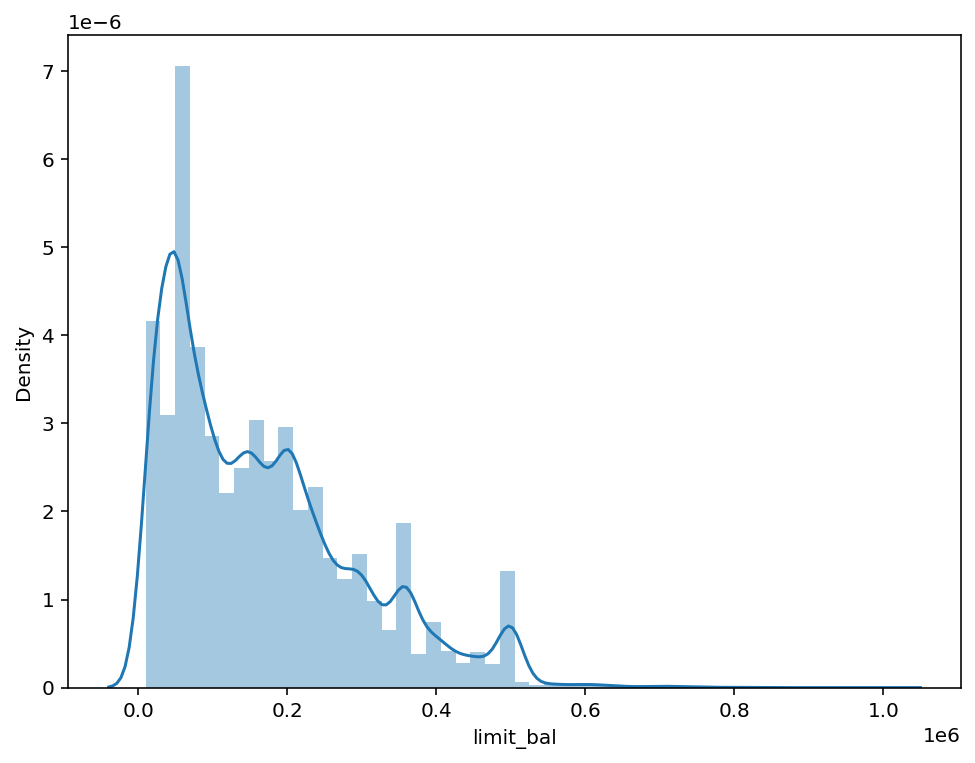

In [118]:
sns.distplot(df.limit_bal)

<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

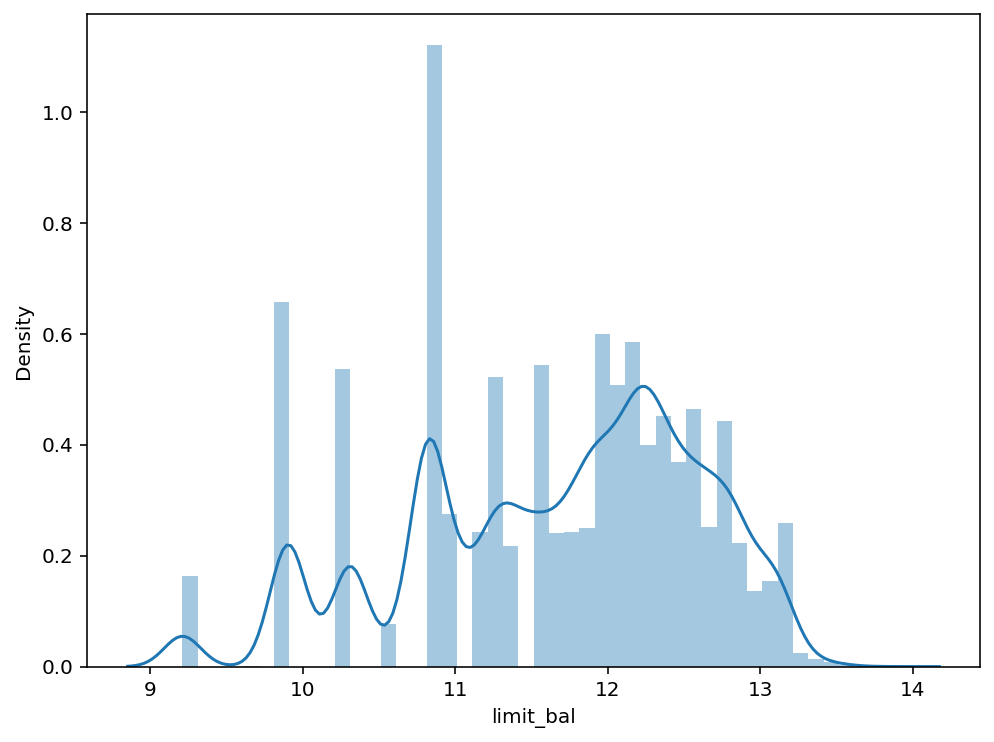

In [120]:
sns.distplot(np.log(df.limit_bal))

<AxesSubplot:xlabel='age', ylabel='Density'>

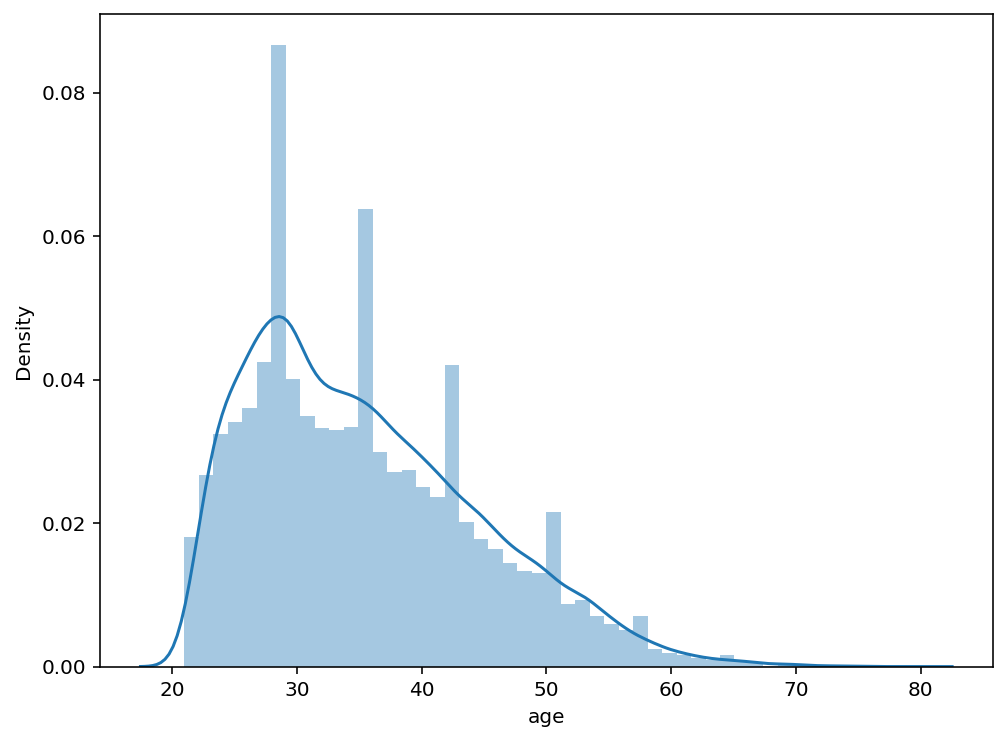

In [121]:
sns.distplot(df.age)

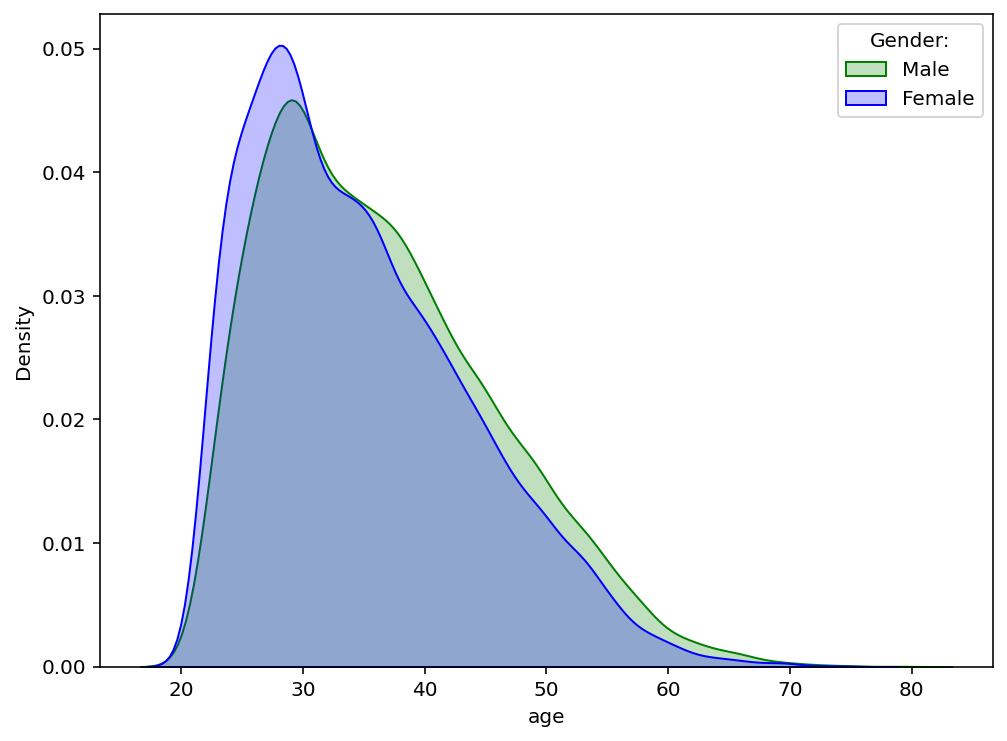

In [18]:
sns.distplot(df.loc[df.sex=='Male', 'age'], 
             hist=False, color='green', 
             kde_kws={'shade': True},
             label='Male')
sns.distplot(df.loc[df.sex=='Female', 'age'], 
             hist=False, color='blue', 
             kde_kws={'shade': True},
             label='Female')
plt.legend(title='Gender:')
plt.show()

### 스캐터플롯
- pairplot()

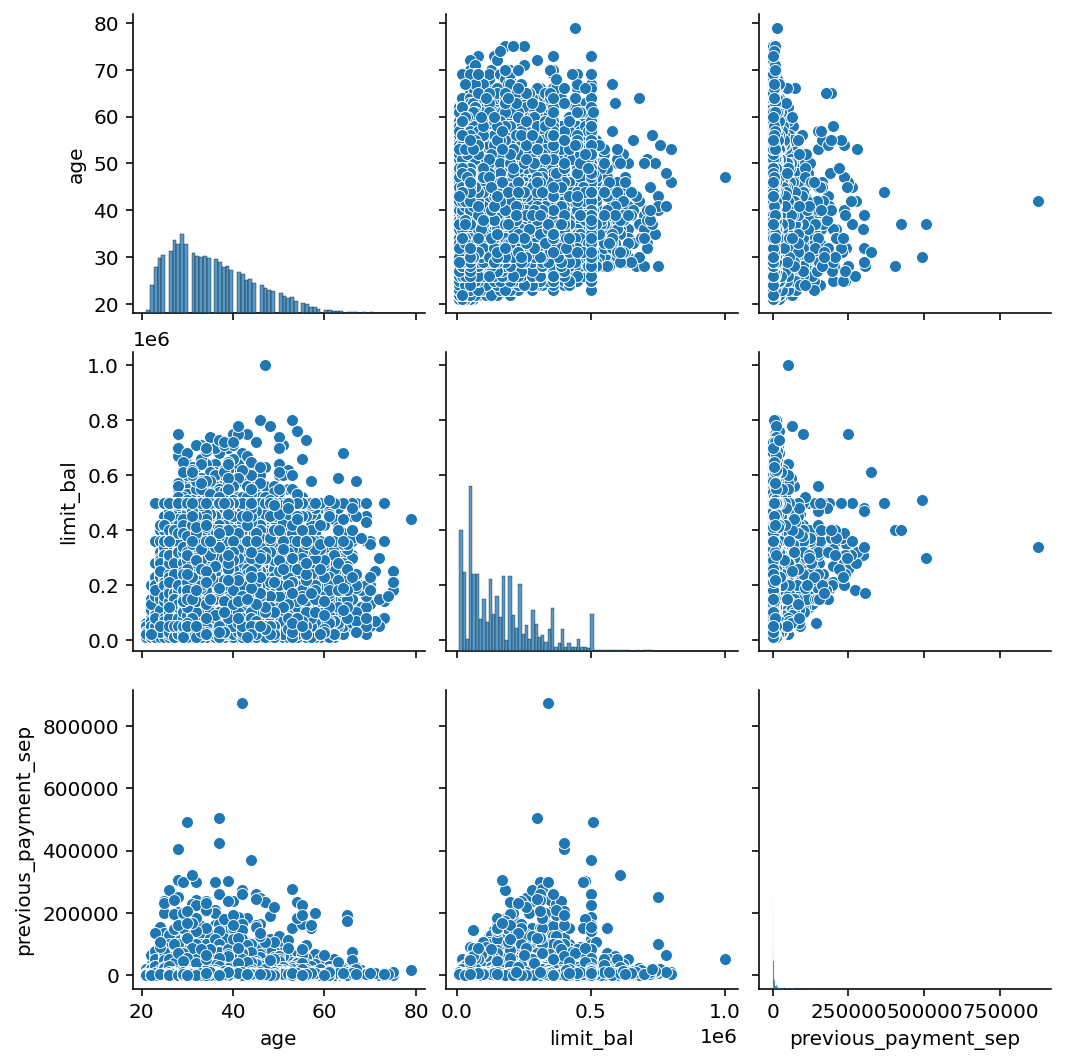

In [19]:
sns.pairplot(df[['age', 'limit_bal', 'previous_payment_sep']])

- 성별을 구분 (hue)

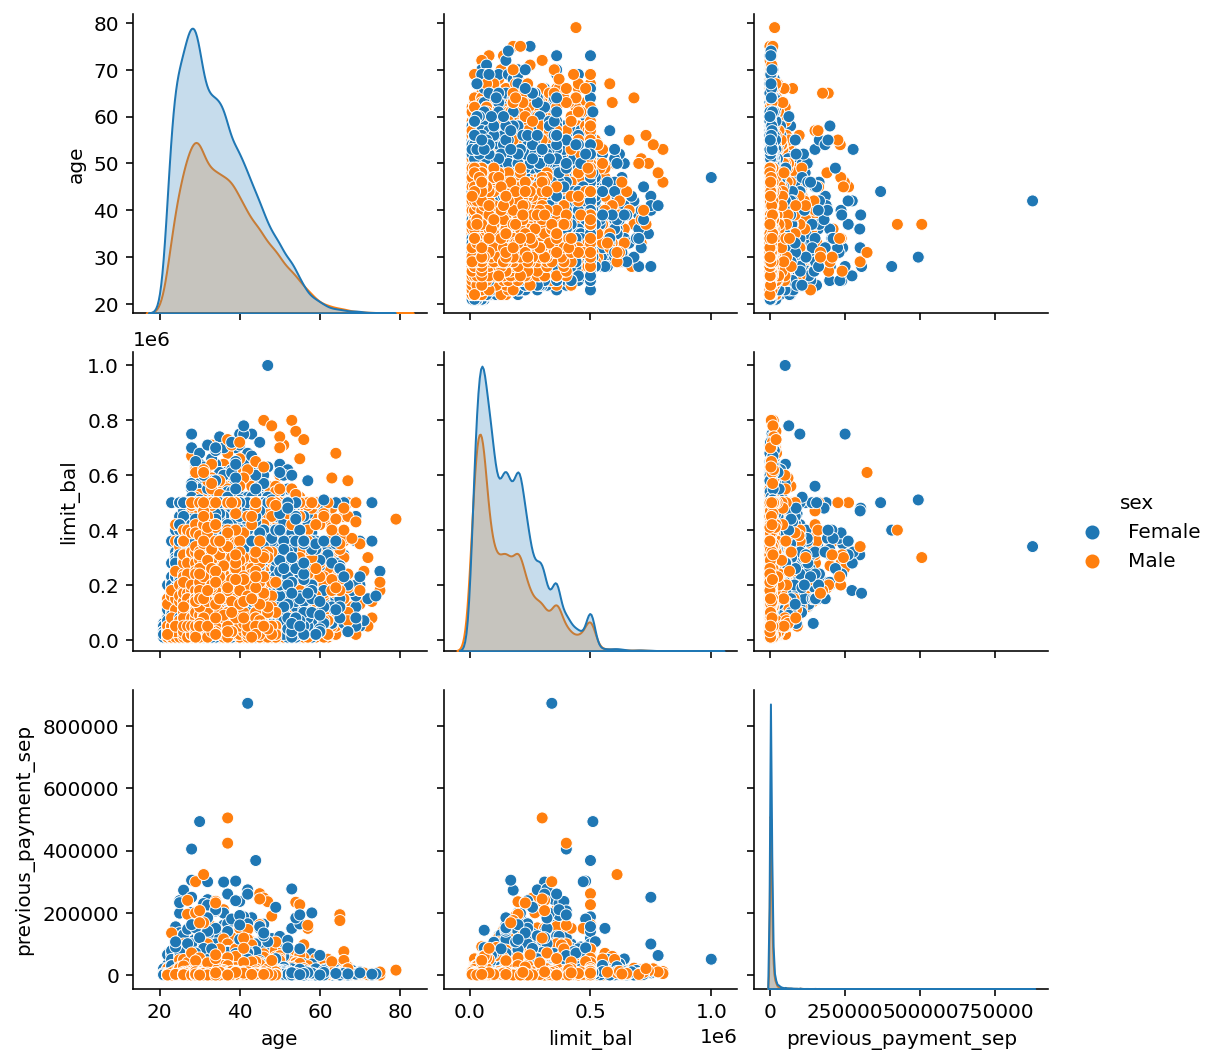

In [21]:
sns.pairplot(df[['sex','age', 'limit_bal', 'previous_payment_sep']],
            hue='sex')

### 목적 변수와의 상관계수

In [22]:
df.select_dtypes(include='number').corr()[['default_payment_next_month']].sort_values(['default_payment_next_month'])

,default_payment_next_month
limit_bal,-0.153520
previous_payment_sep,-0.072929
previous_payment_aug,-0.058579
previous_payment_jun,-0.056827
previous_payment_jul,-0.056250
previous_payment_may,-0.055124
previous_payment_apr,-0.053183
bill_statement_sep,-0.019644
bill_statement_aug,-0.014193
bill_statement_jul,-0.014076


<AxesSubplot:xlabel='education', ylabel='limit_bal'>

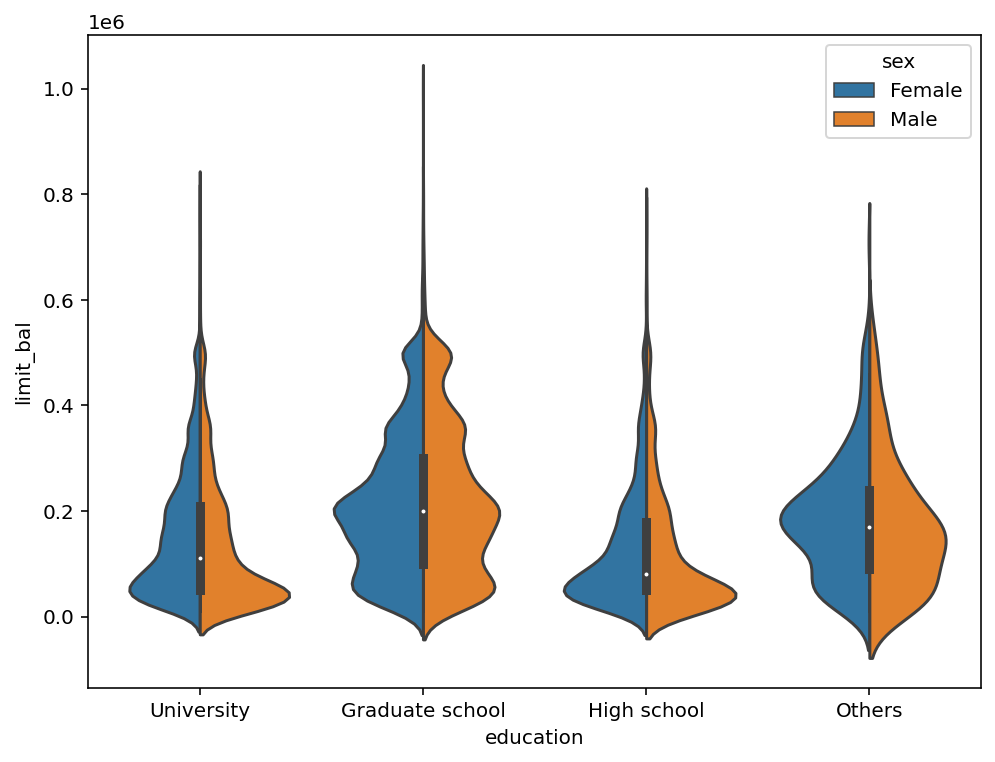

In [23]:
sns.violinplot(x='education', y='limit_bal', 
                    hue='sex', split=True, data=df)

## 카테고리 변수

In [24]:
df.describe(include='object').T

,count,unique,top,freq
sex,30000,2,Female,18112
education,30000,4,University,14030
marriage,30000,3,Single,15964
payment_status_sep,30000,10,Unknown,17496
payment_status_aug,30000,10,Unknown,19512
payment_status_jul,30000,10,Unknown,19849
payment_status_jun,30000,10,Unknown,20803
payment_status_may,30000,9,Unknown,21493
payment_status_apr,30000,9,Unknown,21181


### 빈도수 보기
- countplot()

<AxesSubplot:xlabel='default_payment_next_month', ylabel='count'>

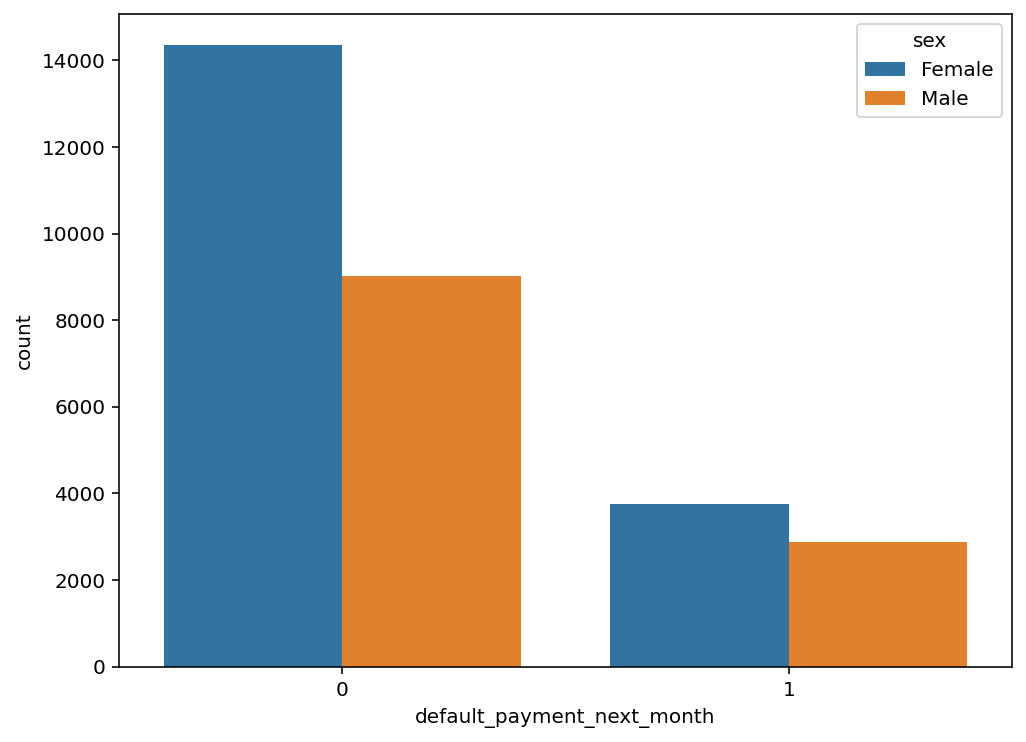

In [25]:
sns.countplot('default_payment_next_month', hue='sex', data=df)

### 비율 보기|
- 막대 그래프 보기
- value_counts(normalize=True) 사용

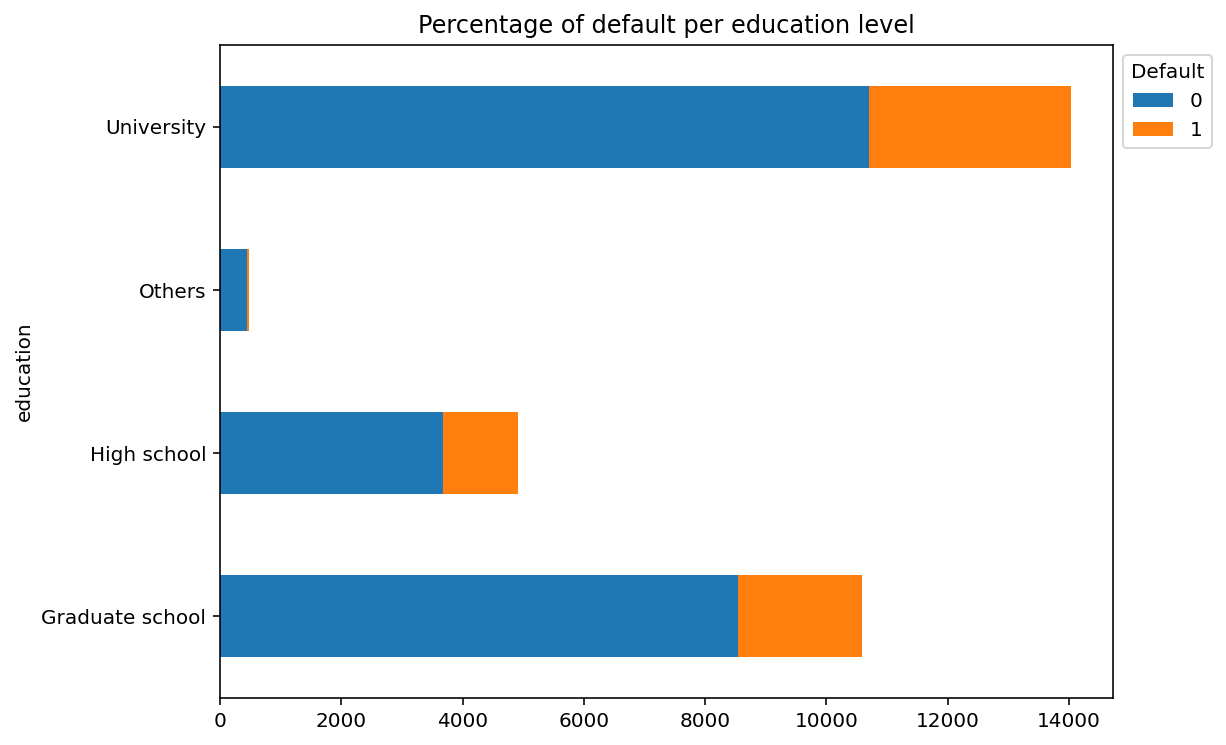

In [53]:
ax = df.groupby('education')['default_payment_next_month'] \
       .value_counts().unstack().plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level')
ax.legend(title='Default', bbox_to_anchor=(1,1)) 
plt.show()

## 특성 추출

In [122]:
df_raw = df.copy()

In [123]:
X = df.copy()
y = X.pop('default_payment_next_month')

In [124]:
cat_features = X.select_dtypes(include='object').columns.to_list()
cat_features

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

In [125]:
cont_features = X.select_dtypes(include=['int', 'float']).columns.to_list()
cont_features

['limit_bal',
 'age',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

### 카테고리 인코딩

In [126]:
X_cat = pd.get_dummies(X, columns=cat_features)
X_cat.shape

(30000, 81)

### 로그변환

<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

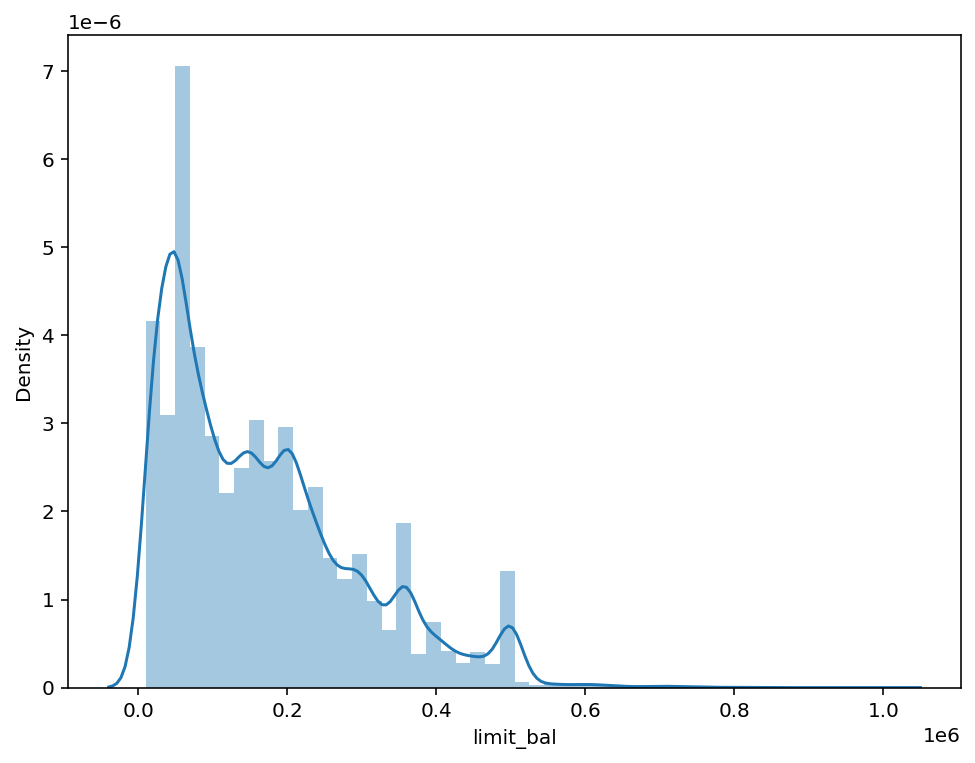

In [127]:
sns.distplot(X_cat.limit_bal)

<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

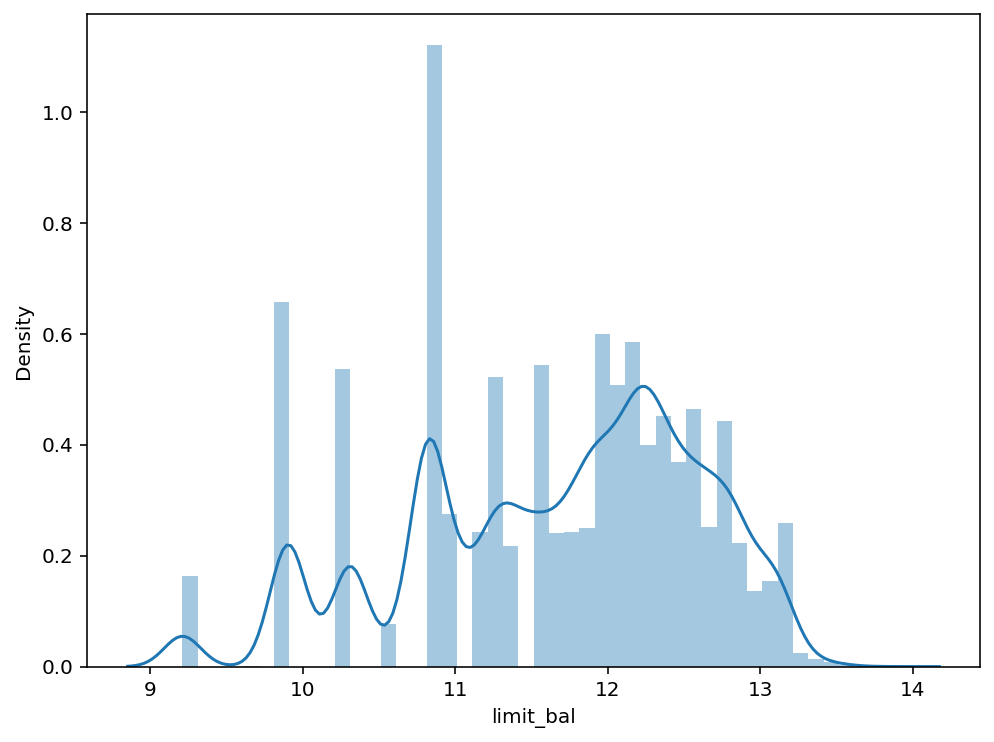

In [128]:
sns.distplot(np.log(X_cat.limit_bal))

In [129]:
X_cat.limit_bal = np.log(X_cat.limit_bal)
X_cat[:3]

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,payment_status_may_Unknown,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 8 months,payment_status_apr_Unknown
ID,,,,,,,,,,,,,,,,,,,,,
1,9.903488,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,1
2,11.695247,26,2682,1725,2682,3272,3455,3261,0,1000,...,1,0,1,0,0,0,0,0,0,0
3,11.407565,34,29239,14027,13559,14331,14948,15549,1518,1500,...,1,0,0,0,0,0,0,0,0,1


### 스케일링

In [55]:
X_sc = X_cat.copy()
scaler = StandardScaler()
X_sc[cont_features] = scaler.fit_transform(X_sc[cont_features])
X_sc

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,payment_status_may_Unknown,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 8 months,payment_status_apr_Unknown
ID,,,,,,,,,,,,,,,,,,,,,
1,-1.931232,-1.246020,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,...,1,0,0,0,0,0,0,0,0,1
2,0.073983,-1.029047,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,...,1,0,1,0,0,0,0,0,0,0
3,-0.226335,-0.161156,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,...,1,0,0,0,0,0,0,0,0,1
4,-0.864222,0.164303,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,...,1,0,0,0,0,0,0,0,0,1
5,-0.864222,2.334029,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,0.683271,0.381275,1.870379,2.018136,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,...,1,0,0,0,0,0,0,0,0,1
29997,0.301883,0.815221,-0.672786,-0.665299,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,...,1,0,0,0,0,0,0,0,0,1
29998,-1.447390,0.164303,-0.647227,-0.643830,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,...,1,0,0,0,0,0,0,0,0,1


# 분류 모델

- 스케일링 데이터 사용
- 모델 성능 비교

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y)

## 모델 성능 비교

In [59]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

## 선형분류

In [60]:
lin = SGDClassifier()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)
show_clf_result(y_test, y_pred)

[[5577  244]
 [1119  560]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5821
           1       0.70      0.33      0.45      1679

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.67      7500
weighted avg       0.80      0.82      0.79      7500



## (연습) 로지스틱 회귀 모델로 구현하시오

In [146]:
# (풀이)



- 스케일링 하지 않은 데이터 사용

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y)

In [131]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

[[5486  340]
 [1072  602]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5826
           1       0.64      0.36      0.46      1674

    accuracy                           0.81      7500
   macro avg       0.74      0.65      0.67      7500
weighted avg       0.79      0.81      0.79      7500



## (연습) 랜덤포레스트 모델에서 가장 성능이 좋은 max_depth를 찾아보시오

In [147]:
# (풀이)



## (연습) LGBMClassifier 모델을 구현하고 특성 중요도를 랜덤 포레스트 모델과 비교하시오

In [148]:
# (풀이)



## 정밀도-리콜 선택
- 샘플별로 디폴트가 발생할 확률 구하시

In [145]:
proba_1 = lgbm.predict_proba(X_test)[:,1]
proba_1[:10]

array([0.05247775, 0.23673039, 0.15909752, 0.05455997, 0.19905763,
       0.05945441, 0.7163884 , 0.07601552, 0.17315003, 0.09046981])

## (연습) 디폴트 가능성이 가장 높은 사람 10명을 찾으시오
- ID, 나이, limit_bal 값을 확인하시오

In [149]:
# (풀이)



## (연습) 디폴트를 찾는 정밀도가 0.8 이상이 되는 예측 모델을 만드시오

In [151]:
# (풀이)



## (연습) 디폴트를 찾는 리콜이 0.9 이상이 되는 예측 모델을 만드시오

In [152]:
# (풀이)



## (연습) 최적의 성능을 갖는 결정트리를 찾으시오 (max_depth 찾기)
- 결정트리 그래프로 그리시오

In [153]:
# (풀이)



# 정답

## (연습) 로지스틱 회귀 모델로 구현하시오

In [61]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
show_clf_result(y_test, y_pred)

[[5531  290]
 [1049  630]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5821
           1       0.68      0.38      0.48      1679

    accuracy                           0.82      7500
   macro avg       0.76      0.66      0.69      7500
weighted avg       0.81      0.82      0.80      7500



## (연습) 랜덤포레스트 모델에서 가장 성능이 좋은 max_depth를 찾아보시오

In [67]:
res = []
for i in range(2,21):
    rfc = RandomForestClassifier(max_depth=i)
    rfc.fit(X_train, y_train) 
    y_pred = rfc.predict(X_test)
    f1 = f1_score(y_test, y_pred).round(3)
    res.append((i, rfc.score(X_test, y_test).round(3), f1))

<AxesSubplot:xlabel='n'>

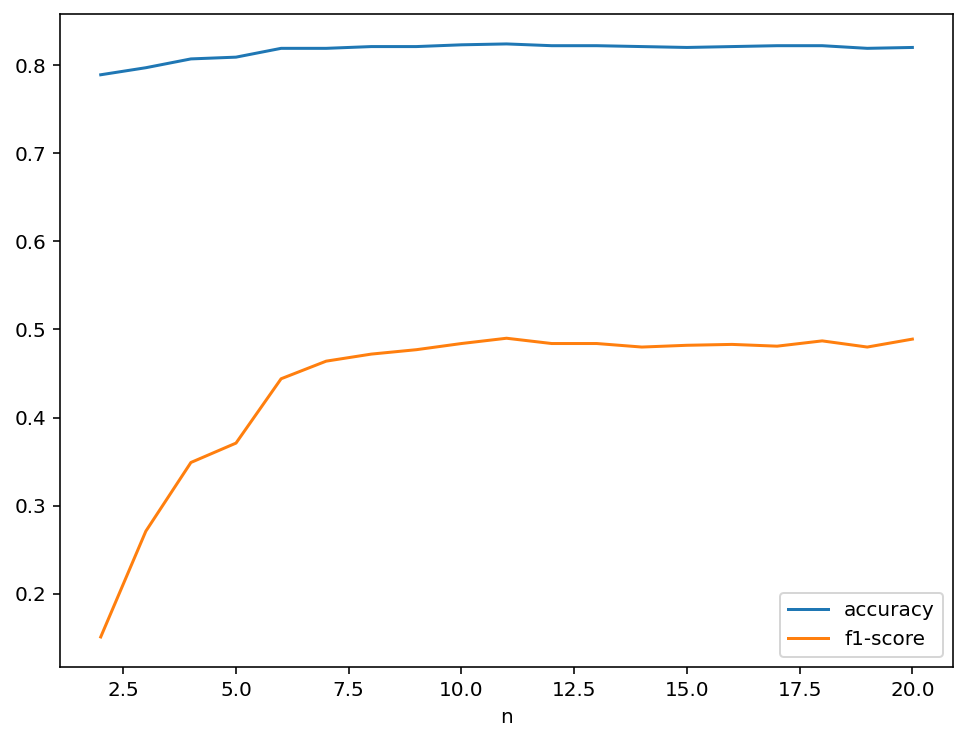

In [68]:
pd.DataFrame(res, columns=['n','accuracy','f1-score']).set_index('n').plot()

In [69]:
for f in np.arange(0.1,0.99,0.1):
    rfc =RandomForestClassifier(max_depth=7, max_features=f)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    print(rfc.score(X_test, y_test).round(4), f1_score(y_test, y_pred).round(3))

0.814 0.427
0.82 0.471
0.821 0.468
0.82 0.463
0.821 0.467
0.82 0.463
0.82 0.462
0.821 0.467
0.821 0.466


## (연습) LGBMClassifier 모델을 구현하고 특성 중요도를 랜덤 포레스트 모델과 비교하시오

In [63]:
from lightgbm import LGBMClassifier

In [132]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, early_stopping_rounds=5, eval_set=(X_test, y_test), verbose=False)
y_pred = lgbm.predict(X_test)
show_clf_result(y_test, y_pred)

[[5511  315]
 [1043  631]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5826
           1       0.67      0.38      0.48      1674

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.69      7500
weighted avg       0.80      0.82      0.80      7500



In [85]:
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

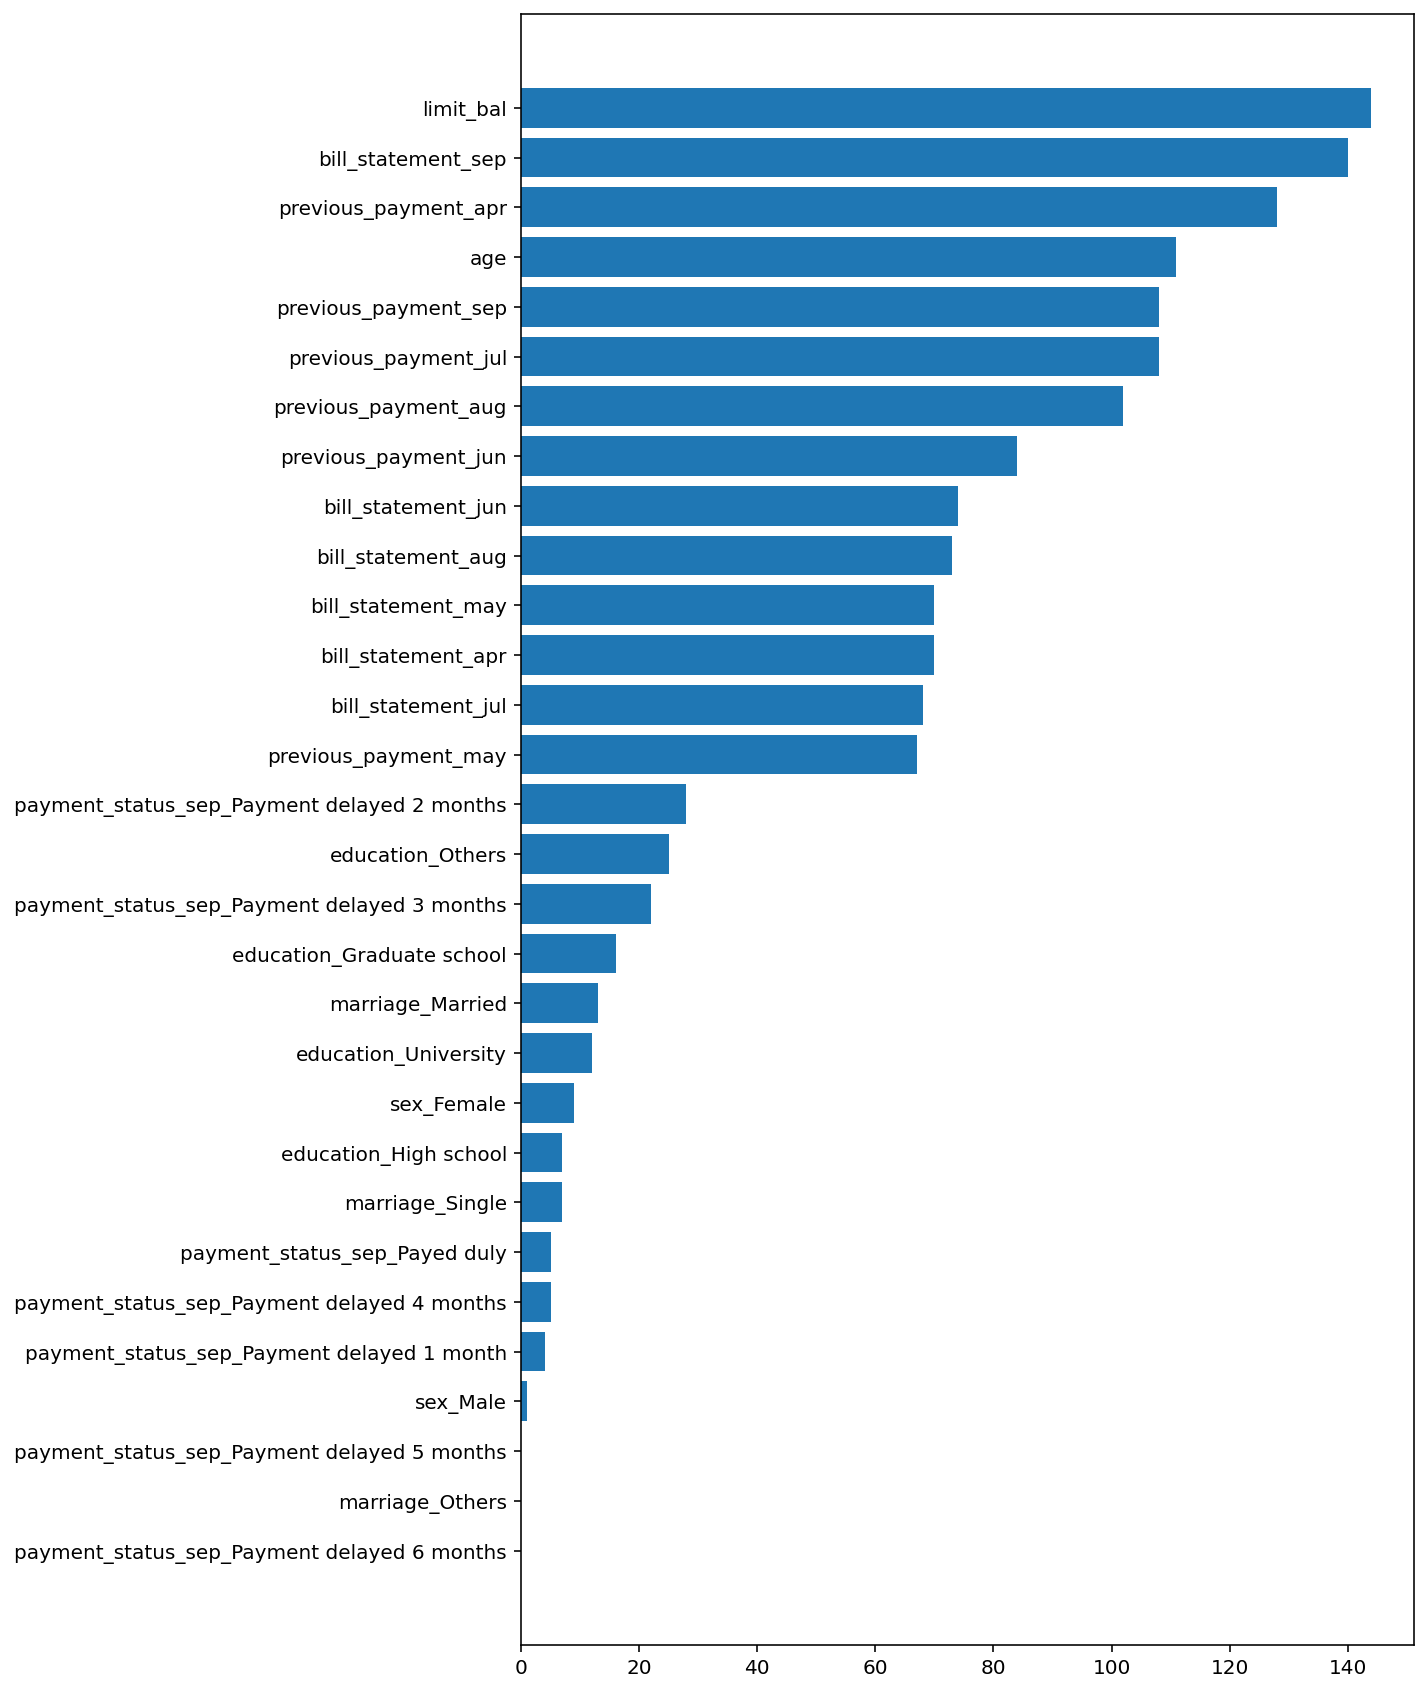

In [86]:
plot_feature_weight(X_cat.columns, lgbm.feature_importances_, 30)

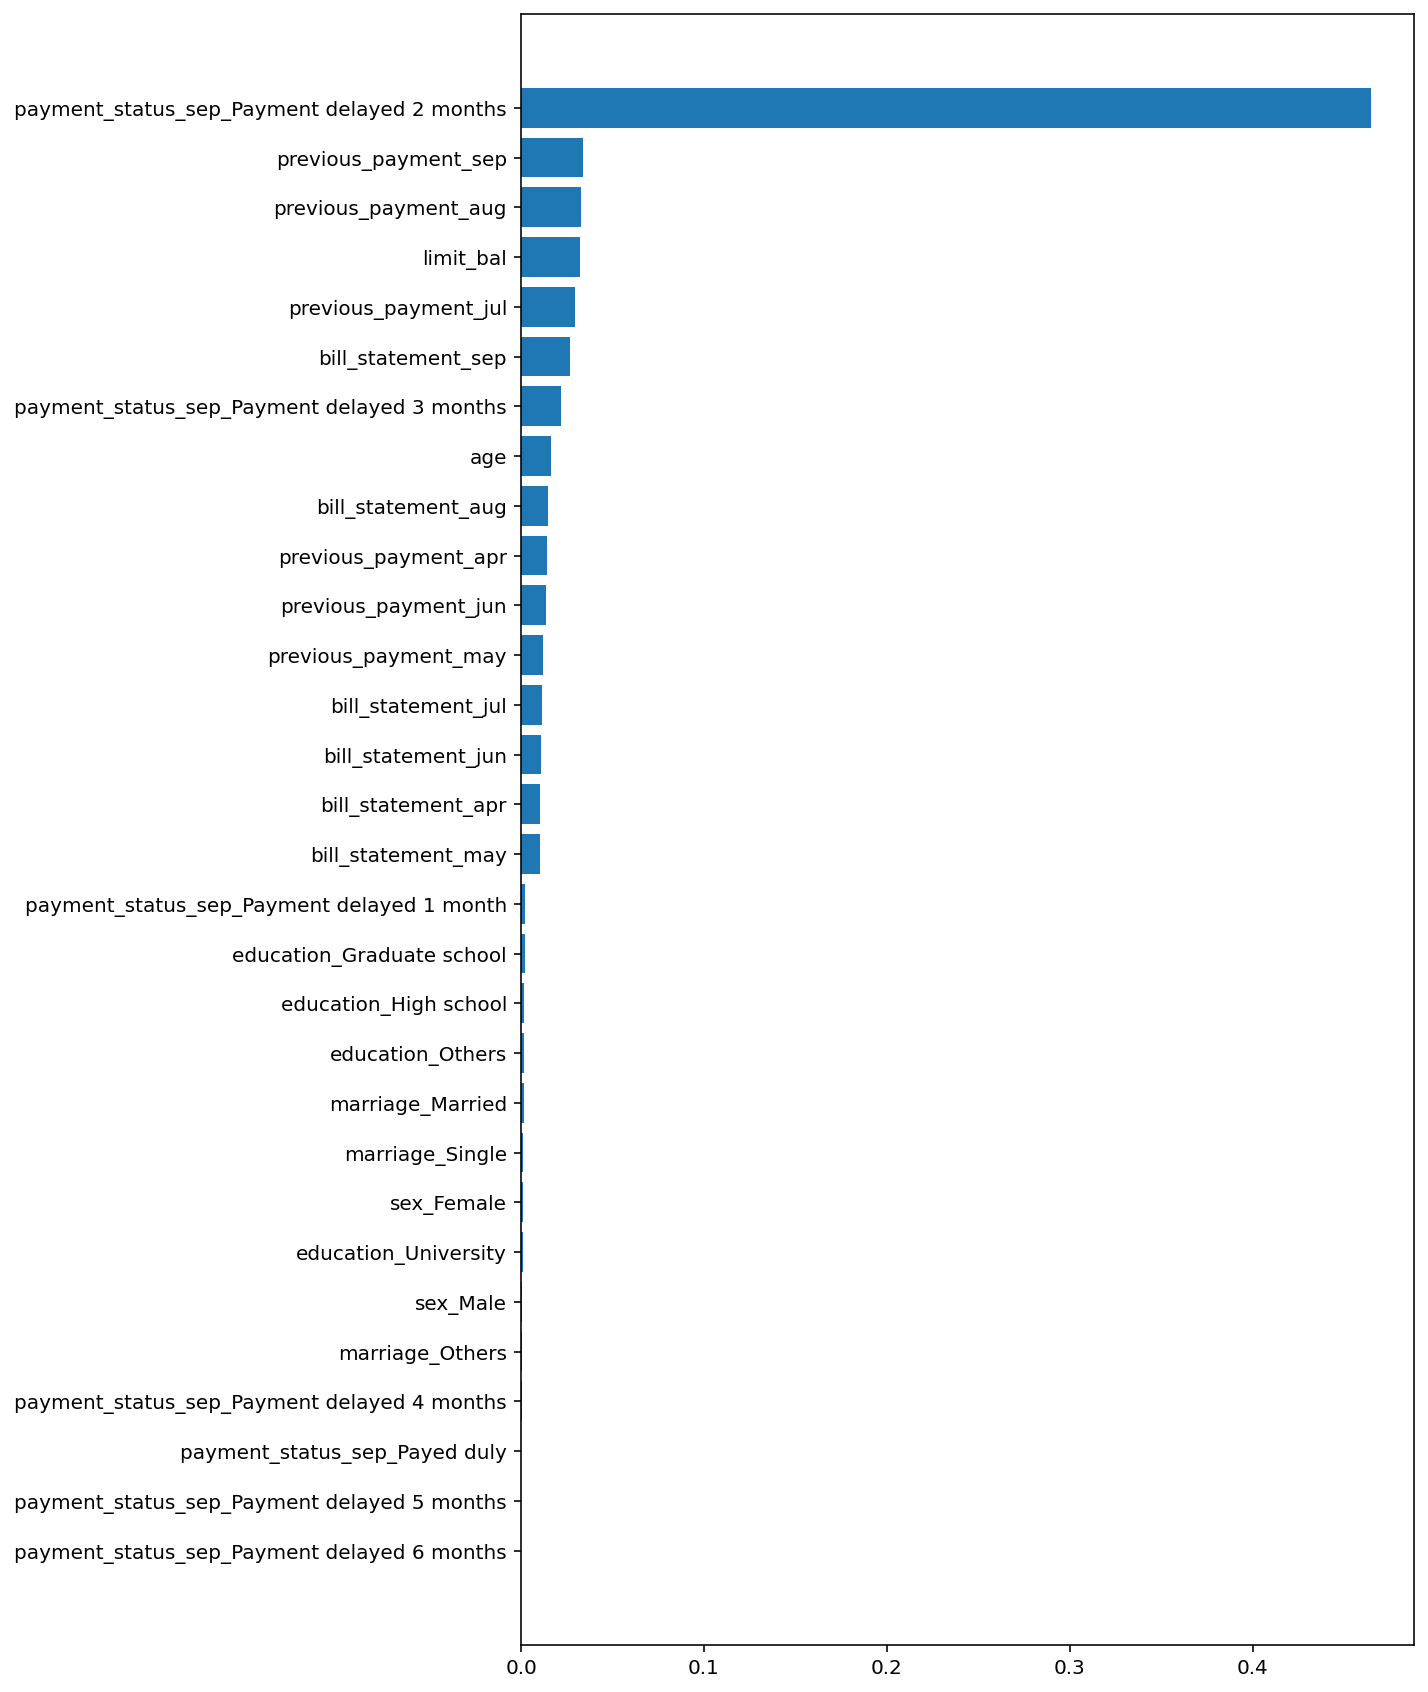

In [87]:
plot_feature_weight(X_cat.columns, rfc.feature_importances_, 30)

## (연습) 디폴트 가능성이 가장 높은 사람 10명을 찾으시오
- ID, 나이, limit_bal 값을 확인하시오

In [138]:
X_test2 = X_test.copy()
X_test2['proba_1'] = proba_1
X_test2.limit_bal = np.e**(X_test2.limit_bal)
X_test2.sort_values('proba_1', ascending=False)[:10]

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 8 months,payment_status_apr_Unknown,proba_1
ID,,,,,,,,,,,,,,,,,,,,,
25054,500000.0,55,4957,4957,4957,4957,4957,4957,0,0,...,0,1,0,0,0,0,0,0,0,0.877329
23692,20000.0,54,6329,8488,8212,7931,8797,8514,2415,0,...,0,1,0,0,0,0,0,0,0,0.875068
11617,30000.0,52,26494,26675,29111,28325,28840,5450,900,3974,...,0,1,0,0,0,0,0,0,0,0.852246
16040,200000.0,31,5000,5000,5000,5000,5000,5000,0,0,...,0,1,0,0,0,0,0,0,0,0.851093
12993,20000.0,22,12553,14551,15016,14480,15093,17077,2500,1000,...,0,0,0,0,0,0,0,0,1,0.849765
17809,10000.0,24,1050,1050,1050,1050,1050,1050,0,0,...,0,0,1,0,0,0,0,0,0,0.845009
21961,50000.0,28,2350,2400,2400,2400,2400,2400,50,0,...,0,0,0,0,0,0,1,0,0,0.840413
26565,200000.0,55,159017,162697,163143,161906,165807,169599,9159,4842,...,0,1,0,0,0,0,0,0,0,0.834563
25511,100000.0,24,81601,79689,85389,83121,88304,90746,0,7000,...,0,1,0,0,0,0,0,0,0,0.833534


<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

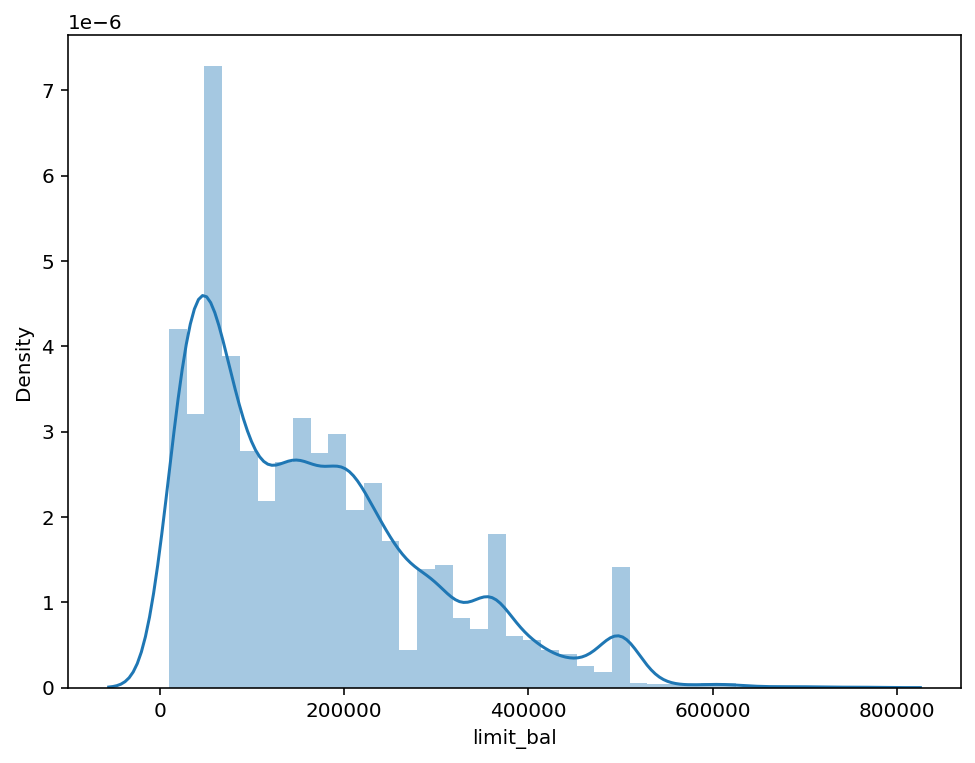

In [140]:
sns.distplot(X_test2.limit_bal)

## (연습) 디폴트를 찾는 정밀도가 0.8 이상이 되는 예측 모델을 만드시오

In [143]:
y_pred_high_precesion = proba_1 > 0.6
show_clf_result(y_test, y_pred_high_precesion)

[[5615  211]
 [1155  519]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5826
           1       0.71      0.31      0.43      1674

    accuracy                           0.82      7500
   macro avg       0.77      0.64      0.66      7500
weighted avg       0.80      0.82      0.79      7500



## (연습) 디폴트를 찾는 리콜이 0.9 이상이 되는 예측 모델을 만드시오

In [144]:
y_pred_high_recall = proba_1 > 0.1
show_clf_result(y_test, y_pred_high_recall)

[[2041 3785]
 [ 138 1536]]
              precision    recall  f1-score   support

           0       0.94      0.35      0.51      5826
           1       0.29      0.92      0.44      1674

    accuracy                           0.48      7500
   macro avg       0.61      0.63      0.47      7500
weighted avg       0.79      0.48      0.49      7500



## (연습) 최적의 성능을 갖는 결정트리를 찾으시오 (max_depth 찾기)
- 결정트리 그래프로 그리시오

In [81]:
res = []
for i in range(2,21):
    dtc = DecisionTreeClassifier(max_depth=i)
    dtc.fit(X_train, y_train) 
    y_pred = dtc.predict(X_test)
    f1 = f1_score(y_test, y_pred).round(3)
    res.append((i, dtc.score(X_test, y_test).round(3), f1))

<AxesSubplot:xlabel='n'>

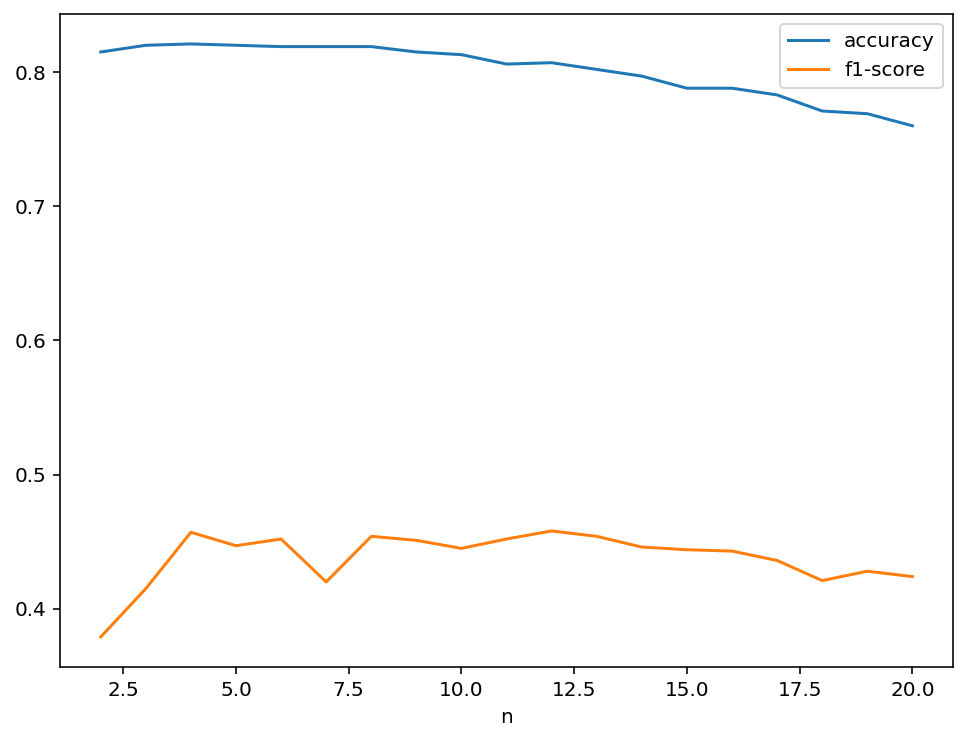

In [82]:
pd.DataFrame(res, columns=['n','accuracy','f1-score']).set_index('n').plot()

In [83]:
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
show_clf_result(y_test, y_pred)

[[5673  187]
 [1162  478]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      5860
           1       0.72      0.29      0.41      1640

    accuracy                           0.82      7500
   macro avg       0.77      0.63      0.65      7500
weighted avg       0.81      0.82      0.79      7500



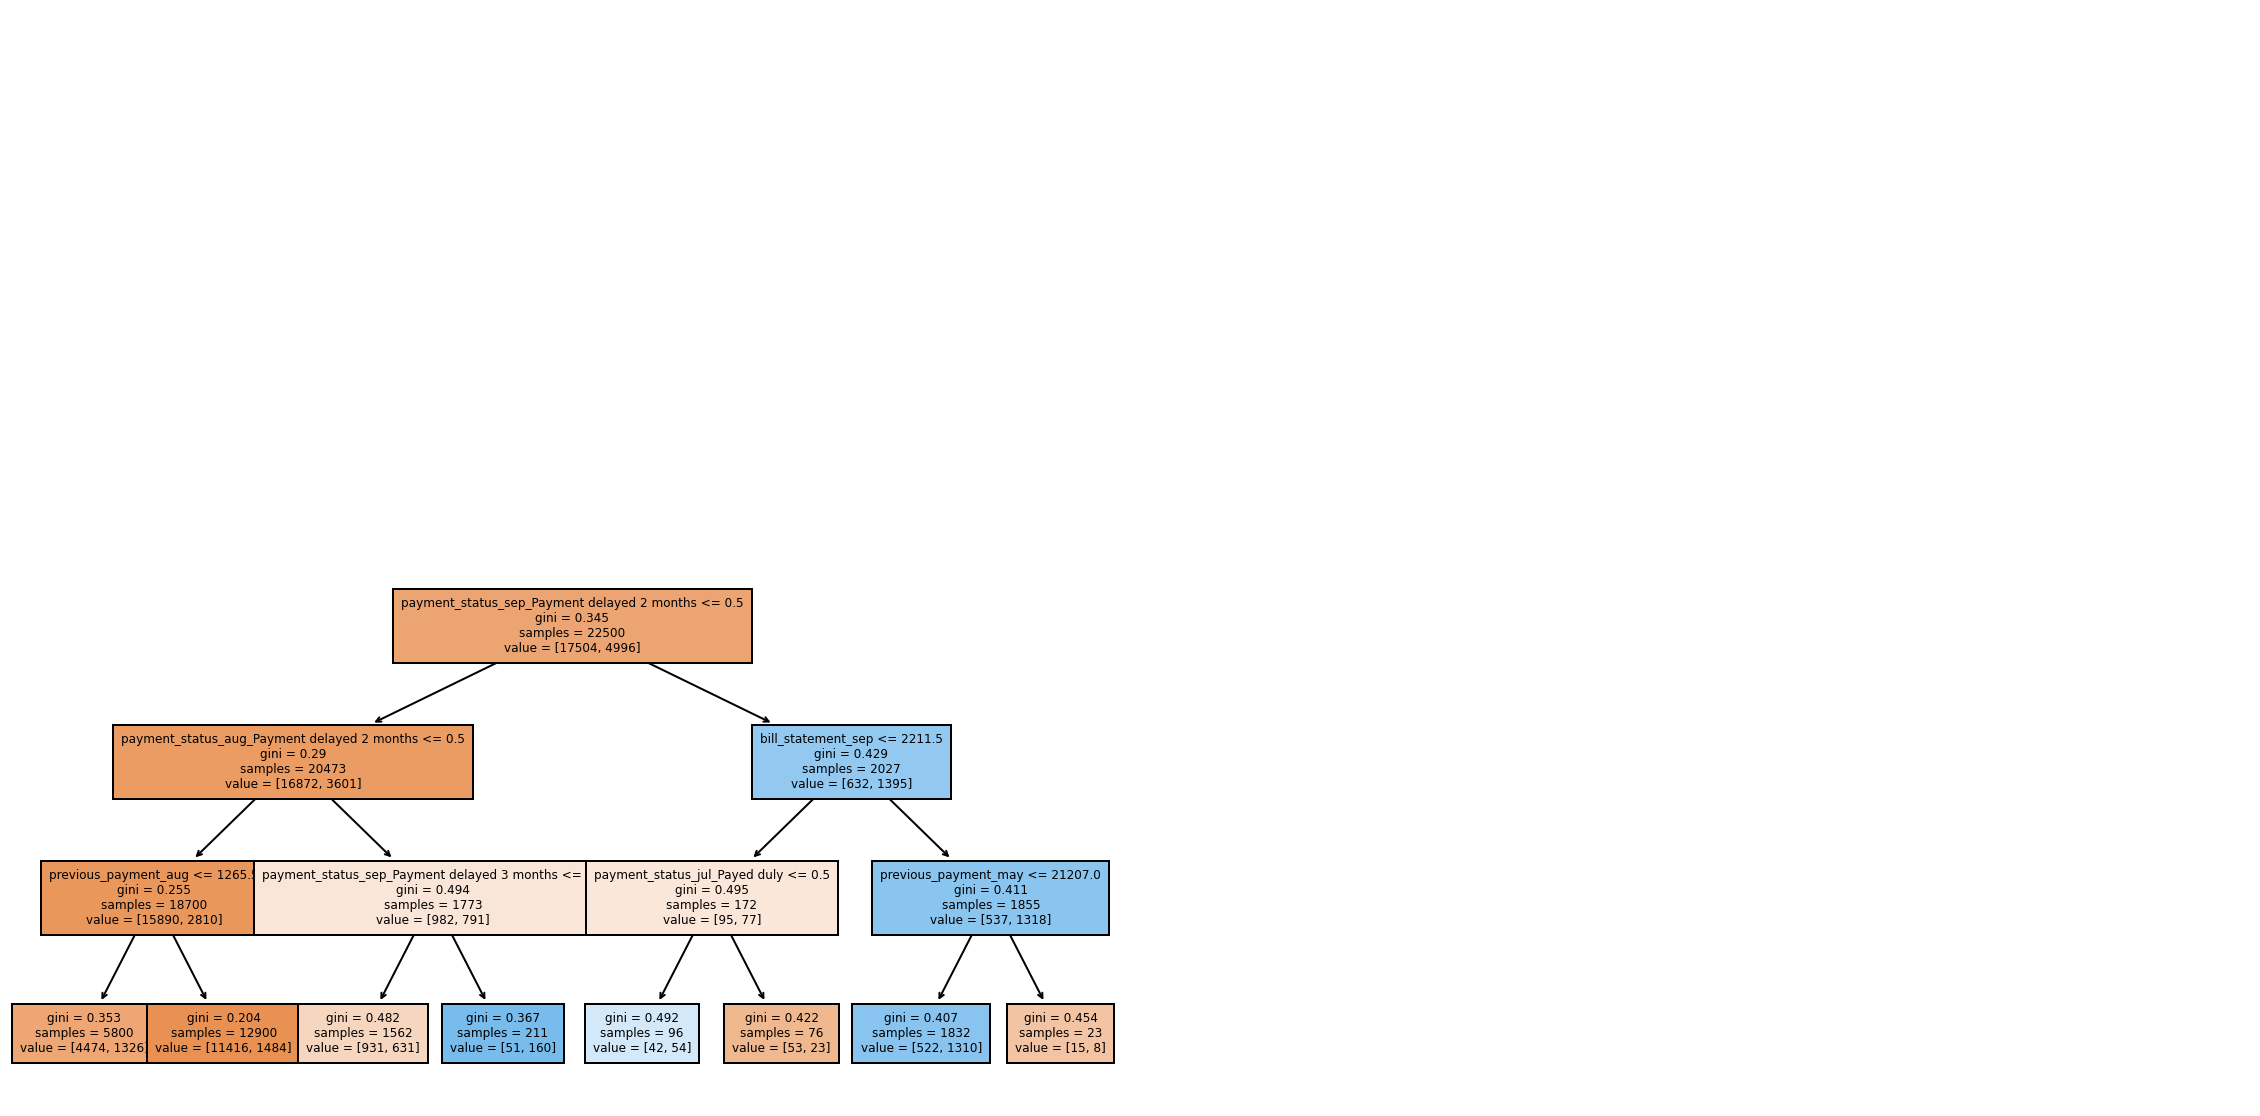

In [84]:
from sklearn import tree
import matplotlib
plt.figure(figsize=(20,10))

tree.plot_tree(dtc, fontsize=6,
              feature_names=X_cat.columns,
              filled=True,
              impurity=True,
              max_depth=3)
plt.show()